### Rahul Birmiwal
### DATA 558
### HW 6

** Requires associated modules (See Code Imports below) to run this notebook**

A weighted-OVR classifier (as described in Lecture 8) applies a weighting parameter rho to the positive and negative terms of the loss function. 

$$ 
 \begin{align*}
  J &= \frac{\rho}{N_+}\sum_{i:y_i=1}Loss(y_i,x_i,\beta)    &+ \frac{1-\rho}{N_-}\sum_{k:y_k=-1}Loss(y_k,x_k,\beta) + RegTerm
 \end{align*}
$$
* Where N+ is the number of positive ys in the data; likewise for N- 
* For example, setting rho=0.5 yields the standard 1/N term in front of the summation. 

The huberized/smooth hinge loss h() writes as in http://qwone.com/~jason/writing/smoothHinge.pdf (2), if we take $ z_i = y_iX_i^T\beta - 0.5 $

It therefore becomes immediate that a weighted cost function for OVR is: 
$$ 
 \begin{align*}
  J &= \frac{\rho}{N_+}\mathbf{1}^Th(\mathbf{y_+}*\mathbf{X_+}^T\beta)
   + \frac{1-\rho}{N_-}\mathbf{1}^Th(\mathbf{y_-}*\mathbf{X_-}^T\beta) + RegTerm
 \end{align*}
$$
Where * denotes the element-wise or Hadamard product

And the gradient is: 
$$ 
 \begin{align*}
  \nabla{J} &= \frac{\rho}{N_+}\mathbf{X_+}^T\mathbf{y_+}*(h'\mathbf(\mathbf{y_+}*\mathbf{X_+}^T\beta))\\  +& 
  \frac{1-\rho}{N_-}\mathbf{X_-}^T\mathbf{y_-}*(h'\mathbf(\mathbf{y_-}*\mathbf{X_-}^T\beta)) + 2\lambda\beta
 \end{align*}
$$

Where X_+, y_+, etc are the sub-matrices of X,y corresponding to the positive (negative) indices of the vector y


## Code Imports

The relevant functions/classes are stored in the following relevant files from below: 
* loss_functions.py: Various loss and gradients i.e. such as those of huberized hinge/squared hinge/logistic, etc. 
* RBLinearSVM_variants.py: Class implementation of a Huberized SVM, Squared-Loss, SVM, etc. 
* multiclass_clfs_variants.py: Class implementation of a weighted-OVR classifier


The relevant class protoypes of interest are: 

```python
class Weighted_OVR_Classifier():
    def __init__(self, rho, loss_fn , method, reduced_rank = False ):
```
* Rho: Balancing parameter
* Loss_fn: Could be 'huberized_hinge', 'squared_hinge'
* Method: Optimizer method, i.e. fastgradalgo or SGD, used for each of its K child OVR classifiers 
* Reduced_rank: True if to perform SVD dimension reduction on the matrix X to a certain threshold of singular values

```python
def train_classifiers(self, X_train, y_train, K, do_lambda_tuning, verbose=True,
                            X_validate = None, y_validate = None, default_lamb = 1.0):
```
* Creates K classifiers
* Do_lambda_tuning: True if to perform cross-validation to optimize lambda for each of the K classifiers

```python
def balancer(X_train,y_train, X_validate, y_validate, loss_fn, method, num_classes ):
```
* Finds optimal value of rho based on scoring on the validation set 


In [22]:


import os
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import random
import importlib 
from matplotlib import pyplot as plt

import loss_functions as my_lf
import RBLinearSVM_variants as my_svm
import multiclass_clfs_variants as my_multi

importlib.reload(my_multi)
importlib.reload(my_svm)
importlib.reload(my_lf)



<module 'loss_functions' from '/Users/rahulbirmiwal/Documents/UWMSDS/DATA558/Competition2/loss_functions.py'>

## DATA LOADING 

In [122]:

vowels = pd.read_csv('vowels.csv') #training set
test_vowels = pd.read_csv('test_vowels.csv') #test set 
print(vowels.head())

   row.names  y    x.1    x.2    x.3    x.4    x.5    x.6    x.7    x.8  \
0          1  1 -3.639  0.418 -0.670  1.779 -0.168  1.627 -0.388  0.529   
1          2  2 -3.327  0.496 -0.694  1.365 -0.265  1.933 -0.363  0.510   
2          3  3 -2.120  0.894 -1.576  0.147 -0.707  1.559 -0.579  0.676   
3          4  4 -2.287  1.809 -1.498  1.012 -1.053  1.060 -0.567  0.235   
4          5  5 -2.598  1.938 -0.846  1.062 -1.633  0.764  0.394 -0.150   

     x.9   x.10  
0 -0.874 -0.814  
1 -0.621 -0.488  
2 -0.809 -0.049  
3 -0.091 -0.795  
4  0.277 -0.396  


In [123]:
y_train = np.array(vowels['y'],dtype=np.int)
y_test = np.array(test_vowels['y'],dtype=np.int)


In [125]:
X_train = np.array(vowels.iloc[:,2:12], dtype = np.float)
X_test = np.array(test_vowels.iloc[:,2:12], dtype = np.float)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)

(528, 10)


## **Train your linear support vector machine with the huberized hinge loss on the the Vowel dataset for the λ = 1. Report your misclassification error for this value of λ.**

Let's first find: 
* 1: Optimal rho, testing in range 0.5,0.10.....1.0 and 
* 2: Then find misclassification error 

In [133]:

importlib.reload(my_multi)
importlib.reload(my_svm)
importlib.reload(my_lf)

best_rho, scores , rho_params = my_multi.balancer(X_train,y_train, X_test, y_test, loss_fn='huberized_hinge',
                           method='fastgradalgo', num_classes=11 )




########### USING RHO = 0.05
Running weighted-OVR classifier with rho=0.05
Instantiaing weighted-one-v-rest classifier using huberized_hinge loss and fastgradalgo optimizer
......training for class num  1
...........number of iterations taken to train =  1000
......training for class num  2
...........number of iterations taken to train =  1000
......training for class num  3
...........number of iterations taken to train =  1000
......training for class num  4
...........number of iterations taken to train =  27
......training for class num  5
...........number of iterations taken to train =  30
......training for class num  6
...........number of iterations taken to train =  16
......training for class num  7
...........number of iterations taken to train =  30
......training for class num  8
...........number of iterations taken to train =  51
......training for class num  9
...........number of iterations taken to train =  1000
......training for class num  10
...........number of 

...........number of iterations taken to train =  1000
......training for class num  11
...........number of iterations taken to train =  1000
...in multiclass predict()
Rho 0.35000000000000003 had accuracy score of 0.2813852813852814
########### USING RHO = 0.4
Running weighted-OVR classifier with rho=0.4
Instantiaing weighted-one-v-rest classifier using huberized_hinge loss and fastgradalgo optimizer
......training for class num  1
...........number of iterations taken to train =  1000
......training for class num  2
...........number of iterations taken to train =  1000
......training for class num  3
...........number of iterations taken to train =  1000
......training for class num  4
...........number of iterations taken to train =  94
......training for class num  5
...........number of iterations taken to train =  112
......training for class num  6
...........number of iterations taken to train =  62
......training for class num  7
...........number of iterations taken to trai

...........number of iterations taken to train =  161
......training for class num  8
...........number of iterations taken to train =  289
......training for class num  9
...........number of iterations taken to train =  1000
......training for class num  10
...........number of iterations taken to train =  1000
......training for class num  11
...........number of iterations taken to train =  1000
...in multiclass predict()
Rho 0.7000000000000001 had accuracy score of 0.3051948051948052
########### USING RHO = 0.7500000000000001
Running weighted-OVR classifier with rho=0.7500000000000001
Instantiaing weighted-one-v-rest classifier using huberized_hinge loss and fastgradalgo optimizer
......training for class num  1
...........number of iterations taken to train =  1000
......training for class num  2
...........number of iterations taken to train =  210
......training for class num  3
...........number of iterations taken to train =  230
......training for class num  4
...........num

## Plot of Rho vs Accuracy

We plot classification accuracy vs the balancing paramter just to see whether it is significant, and it seems like it is...

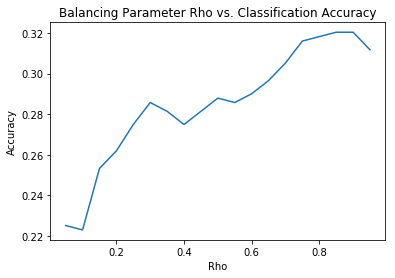

In [134]:
plt.plot(rho_params, scores) #rho_params, scores were generated from a previous run of this 
plt.title("Balancing Parameter Rho vs. Classification Accuracy")
plt.xlabel("Rho")
plt.ylabel("Accuracy")
plt.show()

In [135]:
print("Best rho is {}".format(best_rho))

"""Instantiate w-OVR classifier"""
wOVR_clf = my_multi.Weighted_OVR_Classifier(best_rho, loss_fn = 'huberized_hinge', method='fastgradalgo')
wOVR_clf.train_classifiers(X_train.T,y_train,11,do_lambda_tuning=False, verbose=False)
predictions_huber, score = wOVR_clf.predict(X_test.T, y_test)

print("misclassification error with lambda = 1 is {}".format(1-score))

Best rho is 0.8500000000000001
Instantiaing weighted-one-v-rest classifier using huberized_hinge loss and fastgradalgo optimizer
......training for class num  1
...........number of iterations taken to train =  1000
......training for class num  2
...........number of iterations taken to train =  235
......training for class num  3
...........number of iterations taken to train =  244
......training for class num  4
...........number of iterations taken to train =  181
......training for class num  5
...........number of iterations taken to train =  177
......training for class num  6
...........number of iterations taken to train =  118
......training for class num  7
...........number of iterations taken to train =  179
......training for class num  8
...........number of iterations taken to train =  334
......training for class num  9
...........number of iterations taken to train =  1000
......training for class num  10
...........number of iterations taken to train =  267
......tr

## **Run cross-validation to find the optimal value of λ. Report your misclassification error for that value of λ.**

* We first try tuning lambda on the **local** level, using a global rho value = 0.85 constant across the K classifiers. We do this by setting do_lambda_tuning to True. 
* Hopefully we get a better error than 68%....

In [136]:
"""CROSS-VALIDATION HUBER"""
importlib.reload(my_multi)
importlib.reload(my_svm)
importlib.reload(my_lf)

wOVR_clf = my_multi.Weighted_OVR_Classifier(best_rho, loss_fn = 'huberized_hinge', method='fastgradalgo')
wOVR_clf.train_classifiers(X_train = X_train.T, 
                           y_train = y_train, 
                           K=11, 
                           do_lambda_tuning=True, 
                           verbose=False, 
                           X_validate = X_test.T, 
                           y_validate = y_test)
predictions_huber, score = wOVR_clf.predict(X_test.T, y_test)

print(score)

Instantiaing weighted-one-v-rest classifier using huberized_hinge loss and fastgradalgo optimizer
......training for class num  1
********* TUNING ITS LAMBDA
............Running classifier with lambda=0.0001
...........number of iterations taken to train =  1000
.............!!!!!!!!!!!! Lambda 0.0001 had accuracy score of 0.70995670995671
............Running classifier with lambda=0.001
...........number of iterations taken to train =  1000
.............!!!!!!!!!!!! Lambda 0.001 had accuracy score of 0.7359307359307359
............Running classifier with lambda=0.01
...........number of iterations taken to train =  1000
.............!!!!!!!!!!!! Lambda 0.01 had accuracy score of 0.7359307359307359
............Running classifier with lambda=0.1
...........number of iterations taken to train =  1000
.............!!!!!!!!!!!! Lambda 0.1 had accuracy score of 0.6883116883116883
............Running classifier with lambda=1
...........number of iterations taken to train =  1000
............

...........number of iterations taken to train =  1000
.............!!!!!!!!!!!! Lambda 10 had accuracy score of 0.5995670995670995
............Running classifier with lambda=50
...........number of iterations taken to train =  1000
.............!!!!!!!!!!!! Lambda 50 had accuracy score of 0.5995670995670995
&@&@&@&&@&@&@ BEST LAMBDA FOR CLASS 6 is 0.0001
...........number of iterations taken to train =  1000
......training for class num  7
********* TUNING ITS LAMBDA
............Running classifier with lambda=0.0001
...........number of iterations taken to train =  1000
.............!!!!!!!!!!!! Lambda 0.0001 had accuracy score of 0.5108225108225108
............Running classifier with lambda=0.001
...........number of iterations taken to train =  1000
.............!!!!!!!!!!!! Lambda 0.001 had accuracy score of 0.5173160173160173
............Running classifier with lambda=0.01
...........number of iterations taken to train =  1000
.............!!!!!!!!!!!! Lambda 0.01 had accuracy sco

**Hmmmm...we got an error rate of 72%...WORSE than before. So therefore  keeping rho on the "global" level, and minimizing each of K classifiers w.r.t their own lambdas on the "local" level, didn't seem to really work. Let's try keeping rho and lambda both on the global level...**

In [137]:
""" LAMDA GLOBAL  BALANCER"""
importlib.reload(my_multi)
importlib.reload(my_svm)
importlib.reload(my_lf)

(best_lamb,scores,lamb_params) = my_multi.balancer_lambda(X_train,y_train, X_test,y_test, best_rho, 
                                                        'huberized_hinge', 'fastgradalgo', 11 )

########### USING LAM = 0.0001, RHO = 0.8500000000000001 
Instantiaing weighted-one-v-rest classifier using huberized_hinge loss and fastgradalgo optimizer
......training for class num  1
...........number of iterations taken to train =  1000
......training for class num  2
...........number of iterations taken to train =  1000
......training for class num  3
...........number of iterations taken to train =  1000
......training for class num  4
...........number of iterations taken to train =  1000
......training for class num  5
...........number of iterations taken to train =  1000
......training for class num  6
...........number of iterations taken to train =  1000
......training for class num  7
...........number of iterations taken to train =  1000
......training for class num  8
...........number of iterations taken to train =  1000
......training for class num  9
...........number of iterations taken to train =  878
......training for class num  10
...........number of iteratio

The best global lambda is 0


Text(0,0.5,'Accuracy')

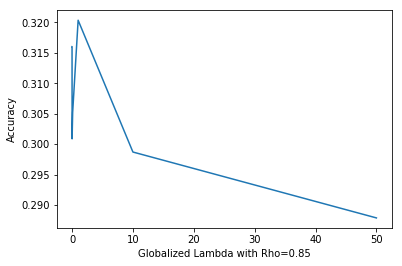

In [140]:
print("The best global lambda is {}".format(best_lamb)) #0.0001
plt.plot(lamb_params,scores)
plt.xlabel("Globalized Lambda with Rho=0.85")
plt.ylabel("Accuracy")


**Now train a classifier with lambda = 0.0001 and rho = 0.85 by setting the default_lamb argument**

In [148]:
"""Instantiate w-OVR with lambda = 0.0001 classifier"""
wOVR_clf = my_multi.Weighted_OVR_Classifier(best_rho, loss_fn = 'huberized_hinge', method='fastgradalgo')
wOVR_clf.train_classifiers(X_train.T,y_train,11,do_lambda_tuning=False, verbose=False, default_lamb=0.0001)
predictions_huber, score = wOVR_clf.predict(X_test.T, y_test)

Instantiaing weighted-one-v-rest classifier using huberized_hinge loss and fastgradalgo optimizer
......training for class num  1
...........number of iterations taken to train =  1000
......training for class num  2
...........number of iterations taken to train =  1000
......training for class num  3
...........number of iterations taken to train =  1000
......training for class num  4
...........number of iterations taken to train =  1000
......training for class num  5
...........number of iterations taken to train =  1000
......training for class num  6
...........number of iterations taken to train =  1000
......training for class num  7
...........number of iterations taken to train =  1000
......training for class num  8
...........number of iterations taken to train =  1000
......training for class num  9
...........number of iterations taken to train =  878
......training for class num  10
...........number of iterations taken to train =  580
......training for class num  11


In [150]:
print("New misclassification error with globally tuned lambda and rho is {}".format(1-score))


New misclassification error with globally tuned lambda and rho is 0.6839826839826839


**...so slight improvement after tuning...!**

## EXPLORING PRE-PROCESSING OF THE *X* MATRIX

This section is more an optional addendum related to Question 2, pertinent to issues surrounding high-dimensional multiclassification problems. 

It is well-known that dimensionality reduction (i.e. rank reduction) of the training/testing matrix X can be achived through singular value decomposition. Namely, thresholding a certain number of singular values to zero lowers transforms the original D x N matrix to one of same dimension, but...lower rank. This in turn reduces the number of columns (rows) required in the matrix multiplication of U and V. 

That is, say we select 6 out of the 10 singular values. Then we need only left multiply by the sigma matrix S by the first 6 eigenvectors of XX^T, and right multiply S by the first 6 eigenvectors of X^TX. This can/should lead to less computationsn required, at the cost of prediction accuracy of course. The question is, how much accuracy is lost in the lower-rank approximation of the matrix X. We examine this below: 


In [151]:
def svd(X, threshold):
    (U,S,VH) = np.linalg.svd(X, full_matrices=False)
    """ U is d x n
        S is n x 1 vector
        VH is n x n
    """
    num_singular_vals = len(S)
    thresh = math.floor(threshold*num_singular_vals)
    truncated_singular_vals = S[0:thresh]

    U_r = U[:,0:thresh]
    V_r = VH[0:thresh,]

    X_reducedRank = np.matmul(U_r, np.matmul(np.diag(truncated_singular_vals), V_r))
    return X_reducedRank

In [152]:
A = X_train.T
print(A.shape)

X_full = svd(A, 1)
X_red = svd(A,.6)
print(X_full.shape)
print(X_red.shape)

print(np.allclose(A,X_full))
print(np.allclose(A,X_red,atol=0.7))
print(np.allclose(A,X_red,atol=1.5))

(10, 528)
(10, 528)
(10, 528)
True
False
True


In [153]:
X_train_red = svd(X_train.T, 0.6)
X_test_red = svd(X_test.T, 0.6)
import time

importlib.reload(my_multi)
importlib.reload(my_svm)
importlib.reload(my_lf)
start_time = time.time()
clf_reducedMatrix = my_multi.Weighted_OVR_Classifier(best_rho, loss_fn = 'huberized_hinge', method='fastgradalgo')
clf_reducedMatrix.train_classifiers(X_train = X_train_red, 
                           y_train = y_train, 
                           K=11, 
                           do_lambda_tuning=False, 
                           verbose=False)
print("---Reduced Rank %s seconds ---" % (time.time() - start_time))


start_time = time.time()
clf_fullMatrix = my_multi.Weighted_OVR_Classifier(best_rho, loss_fn = 'huberized_hinge', method='fastgradalgo')
clf_fullMatrix.train_classifiers(X_train = X_train.T, 
                           y_train = y_train, 
                           K=11, 
                           do_lambda_tuning=False, 
                        verbose=False)
print("---Full Rank %s seconds ---" % (time.time() - start_time))

Instantiaing weighted-one-v-rest classifier using huberized_hinge loss and fastgradalgo optimizer
......training for class num  1
...........number of iterations taken to train =  1000
......training for class num  2
...........number of iterations taken to train =  250
......training for class num  3
...........number of iterations taken to train =  1000
......training for class num  4
...........number of iterations taken to train =  151
......training for class num  5
...........number of iterations taken to train =  172
......training for class num  6
...........number of iterations taken to train =  120
......training for class num  7
...........number of iterations taken to train =  180
......training for class num  8
...........number of iterations taken to train =  349
......training for class num  9
...........number of iterations taken to train =  161
......training for class num  10
...........number of iterations taken to train =  1000
......training for class num  11
.....

In [154]:
predictions_huber, score_fullRank = clf_fullMatrix.predict(X_test.T, y_test)
print(score_fullRank)
predictions_huber, score_reducedRank = clf_reducedMatrix.predict(X_test.T, y_test)
print(score_reducedRank) #same as score_reducedRank

...in multiclass predict()
0.3203463203463203
...in multiclass predict()
0.2683982683982684


**Thus thresholding to select the top 60% of singular values led to a ~6 basis point reduction in model accuracy.**

# COMPARISON WITH SKLEARN LINEARSVC

Last but not least we should compare our huberized svm with that of SKLearn

In [115]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, )
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.4090909090909091

## Summary: 

* Our maximum accuracy achieved was ~32%. Scikit's counterpart (not huberized hinge, but rather just squared hinge) yields ~40% accuracy. So it seems that we are relatively on par. 
* The balancing parameter rho significantly compromises/boosts model performance 
* It seems like SVD can be used to reduce to transform the complexity of the full matrix X to that of lower rank 